In [1]:
import graph_tool as gt
import graph_tool.topology as top
import networkx as nx
import numpy as np

In [86]:
k = 6
pattern = nx.cycle_graph(k)
edge_list = list(pattern.edges)

graph = nx.Graph()
nx.add_cycle(graph, range(0, 4))
nx.add_star(graph, range(4-1, 7))
nx.add_cycle(graph, [7-1, 7, 11, 22, 33, 44])
nx.add_cycle(graph, [33, 55, 66, 77, 88, 44])
graph_edge_list = list(graph.edges)

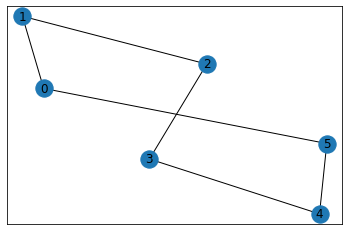

In [87]:
nx.draw_networkx(pattern, with_labels=True)

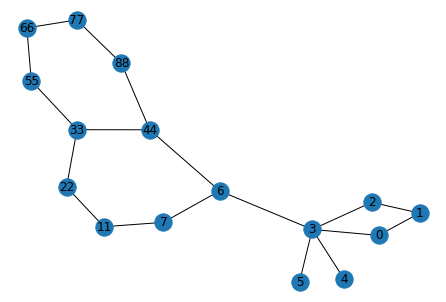

In [88]:
nx.draw(graph, with_labels=True)

In [115]:
get_rings(graph_edge_list)

[(33, 44, 88, 77, 66, 55), (0, 1, 2, 3), (6, 7, 11, 22, 33, 44)]

In [108]:
pattern_gt = gt.Graph(directed=False)
pattern_gt.add_edge_list(edge_list)
graph_gt = gt.Graph(directed=False)
graph_gt.add_edge_list(graph_edge_list)
gt.stats.remove_self_loops(graph_gt)
gt.stats.remove_parallel_edges(graph_gt)  

sub_iso = top.subgraph_isomorphism(pattern_gt, graph_gt, induced=True, subgraph=True, generator=True)

In [113]:
def get_rings(edge_index, max_k=7):
    '''
    '''
#     edge_list = edge_index.numpy().T
    edge_list = edge_index
    graph_gt = gt.Graph(directed=False)
    graph_gt.add_edge_list(edge_list)
    gt.stats.remove_self_loops(graph_gt)
    gt.stats.remove_parallel_edges(graph_gt)
    rings = set()
    sorted_rings = set()
    for k in range(3, max_k+1):
        pattern = nx.cycle_graph(k)
        pattern_edge_list = list(pattern.edges)
        pattern_gt = gt.Graph(directed=False)
        pattern_gt.add_edge_list(pattern_edge_list)
        sub_iso = top.subgraph_isomorphism(pattern_gt, graph_gt, induced=True, subgraph=True, generator=True)
        sub_iso_sets = map(lambda x: tuple(x.a), sub_iso)
        for iso in sub_iso_sets:
            if tuple(sorted(iso)) not in sorted_rings:
                rings.add(iso)
                sorted_rings.add(tuple(sorted(iso)))
    rings = list(rings)
    return rings

In [107]:
for i, iso in enumerate(sub_iso):
    print(i, iso.a)

0 [ 6  7 11 22 33 44]
1 [ 6 44 33 22 11  7]
2 [ 7  6 44 33 22 11]
3 [ 7 11 22 33 44  6]
4 [11  7  6 44 33 22]
5 [11 22 33 44  6  7]
6 [22 11  7  6 44 33]
7 [22 33 44  6  7 11]
8 [33 22 11  7  6 44]
9 [33 44  6  7 11 22]
10 [33 44 88 77 66 55]
11 [33 55 66 77 88 44]
12 [44  6  7 11 22 33]
13 [44 33 22 11  7  6]
14 [44 33 55 66 77 88]
15 [44 88 77 66 55 33]
16 [55 33 44 88 77 66]
17 [55 66 77 88 44 33]
18 [66 55 33 44 88 77]
19 [66 77 88 44 33 55]
20 [77 66 55 33 44 88]
21 [77 88 44 33 55 66]
22 [88 44 33 55 66 77]
23 [88 77 66 55 33 44]


In [138]:
import sys
sys.path.append('./../..')

In [189]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it
import torch
import gudhi as gd
import itertools

from tqdm import tqdm
from data.complex import Chain, Complex
from collections import OrderedDict
from typing import List, Dict
from torch import Tensor
from torch_geometric.typing import Adj


def get_nx_graph(ptg_graph):
    edge_list = ptg_graph.edge_index.numpy().T
    G = nx.Graph()
    G.add_nodes_from(list(range(ptg_graph.num_nodes)))
    G.add_edges_from(edge_list)
    return G


def color_mapper(val, ncolors, max_c=16):
    if val <= max_c:
        return ncolors[int((val / max_c) * (len(ncolors)-1))]
    else:
        return [0.0, 0.0, 0.0]


def draw_legend(colors):
    plt.figure(figsize=(2,2), dpi=100)
    plt.box(False)
    plt.title('Color legend')
    for k, kind in enumerate(sorted(colors)):
        plt.plot([], [], 'o', color=colors[kind], label=kind, markersize=5)
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc='center')
    plt.show()
    plt.close()
    return


def get_faces(simplex):
    '''
        Given a k-simplex as an iterable of nodes, returns all its faces (contained (k-1)-simplices).
        Faces are returned as a set of ordered tuples.
    '''
    k = len(simplex)
    if k == 1:
        raise ValueError("0-simplices do not have faces.")
    return set([tuple(sorted(comb)) for comb in it.combinations(simplex, k-1)])


def lower_adj(a, b, min_k=1, all_simplices=None):
    '''
        Returns True if simplices a, b are lower-adjacent.
        Simplices a, b are lower-adjacent when:
            - their size (k) is larger than 1;
            - they have the same dimension;
            - the share one (k-1)-face.
        Optionally, it is possible to also enforce the shared
        co-face to be present in a set of know simplices (`all_simplices`).
    '''
    assert len(a) == len(b)
    k = len(a)
    intersection = tuple(sorted(set(a) & set(b)))
    result = len(intersection) == k - 1 and k > min_k
    if all_simplices is not None:
        result = result and intersection in all_simplices
    return result


def get_simplex_upper_adjs(simplex, all_facets, all_simplices, non_facets, upper_adjacencies, upper_adjacencies_labeled):
    '''
        Recursive function to compute upper adjacencies between the faces of a given simplex.
        Parameters:
            - `simplex`: input simplex as an iterable of nodes
            - `all_facets`: a set of facets for the complex the simplex belongs to
            - `all_simplices`: set updated during the recursion to keep track of all simplices encountered
            - `non_facets`: set updated during the recursion to keep track of all simplices encountered which are not facets
            - `upper_adjacencies`: dictionary of upper adjacencies updated during recursion
    '''
    # keep track of the simplices encountered;
    # ... and those which do not correspond to any facet
    nodes = tuple(sorted(simplex))
    all_simplices.add(nodes)
    if nodes not in all_facets:
        non_facets.add(nodes)

    # stop recursion if nodes have been reached
    k = len(nodes)
    if k == 1:
        return all_simplices, non_facets, upper_adjacencies, upper_adjacencies_labeled

    # get faces of the input simplex: all of them are
    # considered to be upper adjacent w.r.t present simplex
    faces = get_faces(nodes)
    for face in faces:

        # add adjacencies to all other faces in the simplex
        if face not in upper_adjacencies[k-1]:
            upper_adjacencies[k-1][face] = set()
            upper_adjacencies_labeled[k-1][face] = dict()
        upper_adjacencies[k-1][face] |= faces - {face}
        for neighbor in faces - {face}:
            upper_adjacencies_labeled[k-1][face][neighbor] = nodes

        # recur down w.r.t. present face
        all_simplices, non_facets, upper_adjacencies, upper_adjacencies_labeled = get_simplex_upper_adjs(face, all_facets, all_simplices, non_facets, upper_adjacencies, upper_adjacencies_labeled)

    return all_simplices, non_facets, upper_adjacencies, upper_adjacencies_labeled


def compute_upper_adjs(all_facets, all_facets_by_size, max_size):
    '''
        Computes upper adjacencies for all simplices in a complex.
        The complex is specified in terms of its facets (top-level simplices).
        Here the idea is to iterate on the facets and, for each of them, to recursively compute the upper adjacencies between the constituent simplices.
        Parameters:
            - `all_facets`: the set of facets constituting the complex; each facet is an ordered tuple containing nodes
            - `all_facets_by_size`: dictionary of facets constituting the complex; the dictionary is indexed by the number of nodes in each facet
            - `max_size`: maximum number of nodes for facets to be considered here; e.g. if `max_size` equals 3, then facets are considered only up to triangles
    '''
    # initialize dictionary of adjacencies
    upper_adjacencies = dict()
    upper_adjacencies_labeled = dict()
    for k in range(1, max_size):
        upper_adjacencies[k] = dict()
        upper_adjacencies_labeled[k] = dict()
    all_simplices = set()
    non_facets = set()

    # iterate over sizes
    for k in range(1, max_size+1):
        facets = all_facets_by_size[k]

        # iterate over facets of size k
        for facet in facets:
            all_simplices, non_facets, upper_adjacencies, upper_adjacencies_labeled = get_simplex_upper_adjs(facet, all_facets, all_simplices, non_facets, upper_adjacencies, upper_adjacencies_labeled)

    return all_simplices, non_facets, upper_adjacencies, upper_adjacencies_labeled


def compute_lower_adjs(all_simplices, all_simplices_by_size, max_size):
    '''
        Computes lower adjacencies for all simplices in a complex.
        The complex is specified in terms of all contained simplices -- parameter `all_simplices`, where `all_simplices_by_size` is simply a dictionary of simplices constituting the complex indexed by the number of nodes in each of them.
        Here the idea is to iterate on the facets and, for each of them, to recursively compute the upper adjacencies between the constituent simplices.
        Lastly, `max_size` is maximum number of nodes for simplices to be considered here; e.g. if `max_size` equals 3, then simplices are considered only up to triangles.
    '''
    # initialize dictionary of adjacencies
    lower_adjacencies = dict()
    for k in range(2, max_size+1):
        lower_adjacencies[k] = dict()

    # iterate over sizes
    for k in range(1, max_size+1):
        simplices = all_simplices_by_size[k]

        # iterate over simplices of size k: for each (ordered) couple
        # test wether they are lower adjacent
        for p in range(len(simplices)):
            for pp in range(p+1, len(simplices)):
                nodes_p = simplices[p]
                nodes_pp = simplices[pp]
                if lower_adj(nodes_p, nodes_pp):
                    if nodes_p not in lower_adjacencies[k]:
                        lower_adjacencies[k][nodes_p] = set()
                    if nodes_pp not in lower_adjacencies[k]:
                        lower_adjacencies[k][nodes_pp] = set()
                    # add both directions
                    lower_adjacencies[k][nodes_p].add(nodes_pp)
                    lower_adjacencies[k][nodes_pp].add(nodes_p)

    return lower_adjacencies


def compute_connectivity(all_facets, all_facets_by_size, max_size):
    '''
        Computes the lower and upper connectivities in a complex.
        The complex is specified in terms of its facets (top-level simplices).
        Parameters:
            - `all_facets`: the set of facets constituting the complex; each facet is an ordered tuple containing nodes
            - `all_facets_by_size`: dictionary of facets constituting the complex; the dictionary is indexed by the number of nodes in each facet
            - `max_size`: maximum number of nodes for facets to be considered here; e.g. if `max_size` equals 3, then facets are considered only up to triangles
    '''
    # 1. compute upper adjacencies starting from the facets
    all_simplices, non_facets, upper_adjacencies, upper_adjacencies_labeled = compute_upper_adjs(all_facets, all_facets_by_size, max_size)

    # 2. group all simplices by their size
    all_simplices_by_size = dict()
    for simplex in all_simplices:
        k = len(simplex)
        if k not in all_simplices_by_size:
            all_simplices_by_size[k] = list()
        all_simplices_by_size[k].append(simplex)

    # 3. compute lower_adjacencies
    lower_adjacencies = compute_lower_adjs(all_simplices, all_simplices_by_size, max_size)

    return upper_adjacencies, lower_adjacencies, all_simplices, all_simplices_by_size, upper_adjacencies_labeled


def get_adj_index(simplices, connectivity, size):
    '''
        Transforms a connectivity dictionary into an PyG-like edge index (torch.LongTensor).
        Additionally, it builds dictionaries to map original node tuples to indices and vice-versa.
    '''
    index = {simplex: s for s, simplex in enumerate(simplices)}
    rev_index = {s: simplex for s, simplex in enumerate(simplices)}
    seen = set()
    edges = list()
    for simplex in simplices:
        s = index[simplex]
        neighbors = connectivity.get(simplex, [])
        for neighbor in neighbors:
            edge = tuple(sorted((s, index[neighbor])))
            if not edge in seen:
                edges.append([s, index[neighbor]])
                edges.append([index[neighbor], s])
                seen.add(edge)
    mapping = torch.LongTensor(len(simplices), size)
    for s in rev_index:
        mapping[s] = torch.LongTensor(list(rev_index[s]))
    if len(edges) == 0:
        edges = torch.LongTensor([[],[]])
    else:
        edges = torch.LongTensor(edges).transpose(1,0)
    return edges, mapping


def generate_complex(attributes, labels, upper_indices, lower_indices, mappings, upper_adjs, min_order, max_order):

    # generate mappings nodes -> simplex index
    rev_mappings = dict()
    for order in range(min_order, max_order+1):
        current_rev_map = dict()
        current_map = mappings[order]
        for key in range(current_map.shape[0]):
            current_rev_map[tuple(current_map[key].numpy())] = key
        rev_mappings[order] = current_rev_map

    shared_faces = dict()
    shared_cofaces = dict()
    shared_faces[min_order] = None
    shared_cofaces[max_order] = None
    for order in range(min_order, max_order):

        shared = list()
        lower = lower_indices[order+1].numpy().T
        for link in lower:
            a, b = link
            nodes_a = set(mappings[order+1][a].numpy().tolist())
            nodes_b = set(mappings[order+1][b].numpy().tolist())
            shared_face = rev_mappings[order][tuple(sorted(nodes_a & nodes_b))]
            shared.append(shared_face)
        shared_faces[order+1] = torch.LongTensor(shared)

        shared = list()
        upper = upper_indices[order].numpy().T
        for link in upper:
            a, b = link
            nodes_a = tuple(mappings[order][a].numpy().tolist())
            nodes_b = tuple(mappings[order][b].numpy().tolist())
            shared_coface = rev_mappings[order+1][upper_adjs[order+1][nodes_a][nodes_b]]
            shared.append(shared_coface)
        shared_cofaces[order] = torch.LongTensor(shared)

    chains = list()
    for k in range(min_order, max_order+1):
        try:
            y = labels[k]
        except TypeError:
            y = None
        chains.append(Chain(k, x=attributes[k], y=y, upper_index=upper_indices[k], lower_index=lower_indices[k], mapping=mappings[k], shared_faces=shared_faces[k], shared_cofaces=shared_cofaces[k]))

    try:
        _ = labels.keys()
        y = labels
    except AttributeError:
        y = None
    return Complex(*chains, y=y)


def pyg_to_simplex_tree(edge_index: Tensor, size: int):
    """Constructs a simplex tree from a PyG graph.

    Args:
        edge_index: The edge_index of the graph (a tensor of shape [2, num_edges])
        size: The number of nodes in the graph.
    """
    st = gd.SimplexTree()
    # Add vertices to the simplex.
    for v in range(size):
        st.insert([v])

    # Add the edges to the simplex.
    edges = edge_index.numpy()
    for e in range(edges.shape[1]):
        edge = [edges[0][e], edges[1][e]]
        st.insert(edge)

    return st


def get_simplex_faces(simplex):
    faces = itertools.combinations(simplex, len(simplex) - 1)
    return [tuple(face) for face in faces]


def build_tables(simplex_tree, size):
    complex_dim = simplex_tree.dimension()
    # Each of these data structures has a separate entry per dimension.
    id_maps = [{} for _ in range(complex_dim+1)] # simplex -> id
    simplex_tables = [[] for _ in range(complex_dim+1)] # matrix of simplices
    faces_tables = [[] for _ in range(complex_dim+1)]

    simplex_tables[0] = [[v] for v in range(size)]
    id_maps[0] = {tuple([v]): v for v in range(size)}

    for simplex, _ in simplex_tree.get_simplices():
        dim = len(simplex) - 1
        if dim == 0:
            continue

        # Assign this simplex the next unused ID
        next_id = len(simplex_tables[dim])
        id_maps[dim][tuple(simplex)] = next_id
        simplex_tables[dim].append(simplex)

    return simplex_tables, id_maps


def extract_faces_and_cofaces_from_simplex_tree(simplex_tree, id_maps, complex_dim: int):
    """Build two maps simplex -> its cofaces and simplex -> its faces"""
    # The extra dimension is added just for convenience to avoid treating it as a special case.
    faces = [{} for _ in range(complex_dim+2)]  # simplex -> faces
    cofaces = [{} for _ in range(complex_dim+2)]  # simplex -> cofaces
    faces_tables = [[] for _ in range(complex_dim+1)]

    for simplex, _ in simplex_tree.get_simplices():
        # Extract the relevant face and coface maps
        simplex_dim = len(simplex) - 1
        level_cofaces = cofaces[simplex_dim]
        level_faces = faces[simplex_dim + 1]

        # Add the faces of the simplex to the faces table
        if simplex_dim > 0:
            faces_ids = [id_maps[simplex_dim-1][face] for face in get_simplex_faces(simplex)]
            faces_tables[simplex_dim].append(faces_ids)

        # This operation should be roughly be O(dim_complex), so that is very efficient for us.
        # For details see pages 6-7 https://hal.inria.fr/hal-00707901v1/document
        simplex_cofaces = simplex_tree.get_cofaces(simplex, codimension=1)
        for coface, _ in simplex_cofaces:
            assert len(coface) == len(simplex) + 1

            if tuple(simplex) not in level_cofaces:
                level_cofaces[tuple(simplex)] = list()
            level_cofaces[tuple(simplex)].append(tuple(coface))

            if tuple(coface) not in level_faces:
                level_faces[tuple(coface)] = list()
            level_faces[tuple(coface)].append(tuple(simplex))

    return faces_tables, faces, cofaces


def build_adj_gudhi(faces: List[Dict], cofaces: List[Dict], id_maps: List[Dict], complex_dim: int,
                    include_down_adj: bool):
    """Builds the upper and lower adjacency data structures of the complex

    Args:
        faces: A list of dictionaries of the form
            faces[dim][simplex] -> List[simplex] (the faces)
        cofaces: A list of dictionaries of the form
            cofaces[dim][simplex] -> List[simplex] (the cofaces)
        id_maps: A dictionary from simplex -> simplex_id
    """
    def initialise_structure():
        return [[] for _ in range(complex_dim+1)]

    upper_indexes, lower_indexes = initialise_structure(), initialise_structure()
    all_shared_faces, all_shared_cofaces = initialise_structure(), initialise_structure()

    # Go through all dimensions of the complex
    for dim in range(complex_dim+1):
        # Go through all the simplices at that dimension
        for simplex, id in id_maps[dim].items():
            # Add the upper adjacent neighbours from the level below
            if dim > 0:
                for face1, face2 in itertools.combinations(faces[dim][simplex], 2):
                    id1, id2 = id_maps[dim - 1][face1], id_maps[dim - 1][face2]
                    upper_indexes[dim - 1].extend([[id1, id2], [id2, id1]])
                    all_shared_cofaces[dim - 1].extend([id, id])

            # Add the lower adjacent neighbours from the level above
            if include_down_adj and dim < complex_dim and simplex in cofaces[dim]:
                for coface1, coface2 in itertools.combinations(cofaces[dim][simplex], 2):
                    id1, id2 = id_maps[dim + 1][coface1], id_maps[dim + 1][coface2]
                    lower_indexes[dim + 1].extend([[id1, id2], [id2, id1]])
                    all_shared_faces[dim + 1].extend([id, id])

    return all_shared_faces, all_shared_cofaces, lower_indexes, upper_indexes


def construct_features(vx: Tensor, simplex_tables, init_method: str):
    """Combines the features of the component vertices to initialise the simplex features"""
    features = [vx]
    for dim in range(1, len(simplex_tables)):
        nodes = torch.tensor(simplex_tables[dim], dtype=torch.long).view(-1,)
        # This has shape [simplices * (dim+1), node_feature_dim]
        node_features = torch.index_select(vx, 0, nodes)
        # Reshape to [simplices, (dim+1), node_feature_dim]
        node_features = node_features.view(len(simplex_tables[dim]), dim+1, -1)
        # Reduce along the simplex dimension containing the features of the vertices of the simplex
        if init_method == 'sum':
            features.append(node_features.sum(dim=1))
        elif init_method == 'mean':
            features.append(node_features.mean(dim=1))
        else:
            raise ValueError(f'Init method {init_method} is not supported now.')

    return features


def extract_labels(y, size):
    v_y, complex_y = None, None
    if y is None:
        return v_y, complex_y

    y_shape = list(y.size())
    assert len(y_shape) == 1

    if y_shape[0] == 1:
        # This is a label for the whole graph (for graph classification).
        # We will use it for the complex.
        complex_y = y
    else:
        # This is a label for the vertices of the complex.
        assert y_shape[0] == size
        v_y = y

    return v_y, complex_y


def generate_chain_gudhi(dim, x, all_upper_index, all_lower_index,
                         all_shared_faces, all_shared_cofaces, simplex_tables, faces_tables,
                         complex_dim, y=None, cells=False):
    """Builds a Chain given all the adjacency data extracted from the complex."""
    if dim == 0:
        assert len(all_lower_index[dim]) == 0
        assert len(all_shared_faces[dim]) == 0

    num_simplices_down = len(simplex_tables[dim-1]) if dim > 0 else None
    num_simplices_up = len(simplex_tables[dim+1]) if dim < complex_dim else 0

    up_index = (torch.tensor(all_upper_index[dim], dtype=torch.long).t()
                if len(all_upper_index[dim]) > 0 else None)
    down_index = (torch.tensor(all_lower_index[dim], dtype=torch.long).t()
                  if len(all_lower_index[dim]) > 0 else None)
    shared_cofaces = (torch.tensor(all_shared_cofaces[dim], dtype=torch.long)
                      if len(all_shared_cofaces[dim]) > 0 else None)
    shared_faces = (torch.tensor(all_shared_faces[dim], dtype=torch.long)
                    if len(all_shared_faces[dim]) > 0 else None)
    if len(simplex_tables[dim]) > 0:
        simplex_lengths = list(map(lambda x: len(x), simplex_tables[dim]))
        if max(simplex_lengths) == min(simplex_lengths):
            simplices = torch.tensor(simplex_tables[dim], dtype=torch.long)
        else:
            # In the case of top-level objects of different lengths, then
            # we must be working with rings and cell complexes; we pad with
            # -1 indices to accommodate this scenario.
            assert dim == complex_dim
            assert cells
            max_length = max(simplex_lengths)
            simplices = []
            for s, simplex in enumerate(simplex_tables[dim]):
                if simplex_lengths[s] < max_length:
                    simplices.append(simplex+[-1]*(max_length-simplex_lengths[s]))
                else:
                    simplices.append(simplex)
            simplices = torch.tensor(simplices, dtype=torch.long)
    else:
        simplices = None
    # TODO: Do we need simplicies / mapping anymore in Chain?
    if len(faces_tables[dim]) > 0:
        faces_lengths = list(map(lambda x: len(x), faces_tables[dim]))
        if max(faces_lengths) == min(faces_lengths):
            faces = torch.tensor(faces_tables[dim], dtype=torch.long)
        else:
            # In the case of top-level objects of different lengths, then
            # we must be working with rings and cell complexes; we pad with
            # -1 indices to accommodate this scenario for now. However,
            # this will require proper handling when performing index_select
            # operations and face message passing. (!)
            assert dim == complex_dim
            assert cells
            max_length = max(faces_lengths)
            faces = []
            for f, face in enumerate(faces_tables[dim]):
                if faces_lengths[f] < max_length:
                    faces.append(face+[-1]*(max_length-faces_lengths[f]))
                else:
                    faces.append(face)
            faces = torch.tensor(faces, dtype=torch.long)
    else:
        faces = None

    if num_simplices_down is None:
        assert shared_faces is None
    if num_simplices_up == 0:
        assert shared_cofaces is None

    if up_index is not None:
        assert up_index.size(1) == shared_cofaces.size(0)
        assert num_simplices_up == shared_cofaces.max() + 1
    if down_index is not None:
        assert down_index.size(1) == shared_faces.size(0)
        assert num_simplices_down >= shared_faces.max() + 1

    return Chain(dim=dim, x=x, upper_index=up_index,
                 lower_index=down_index, shared_cofaces=shared_cofaces, shared_faces=shared_faces,
                 mapping=simplices, y=y, num_simplices_down=num_simplices_down,
                 num_simplices_up=num_simplices_up, faces=faces, cells=cells)


def compute_clique_complex_with_gudhi(x: Tensor, edge_index: Adj, size: int,
                                      expansion_dim: int = 2, y: Tensor = None,
                                      include_down_adj=True,
                                      init_method: str = 'sum') -> Complex:
    """Generates a clique complex of a pyG graph via gudhi.

    Args:
        x: The feature matrix for the nodes of the graph
        edge_index: The edge_index of the graph (a tensor of shape [2, num_edges])
        size: The number of nodes in the graph
        expansion_dim: The dimension to expand the simplex to.
        y: Labels for the graph nodes or a label for the whole graph.
        include_down_adj: Whether to add down adj in the complex or not
        init_method: How to initialise features at higher levels.
    """
    assert x is not None
    assert isinstance(edge_index, Tensor)  # Support only tensor edge_index for now

    # Creates the gudhi-based simplicial complex
    simplex_tree = pyg_to_simplex_tree(edge_index, size)
    simplex_tree.expansion(expansion_dim)  # Computes the clique complex up to the desired dim.
    complex_dim = simplex_tree.dimension()  # See what is the dimension of the complex now.

    # Builds tables of the simplicial complexes at each level and their IDs
    simplex_tables, id_maps = build_tables(simplex_tree, size)

    # Extracts the faces and cofaces of each simplex in the complex
    faces_tables, faces, co_faces = (
        extract_faces_and_cofaces_from_simplex_tree(simplex_tree, id_maps, complex_dim))

    # Computes the adjacencies between all the simplexes in the complex
    shared_faces, shared_cofaces, lower_idx, upper_idx = build_adj_gudhi(faces, co_faces, id_maps,
                                                                         complex_dim,
                                                                         include_down_adj)

    # Construct features for the higher dimensions
    # TODO: Make this handle edge features as well and add alternative options to compute this.
    xs = construct_features(x, simplex_tables, init_method)

    # Initialise the node / complex labels
    v_y, complex_y = extract_labels(y, size)

    chains = []
    for i in range(complex_dim+1):
        y = v_y if i == 0 else None
        chain = generate_chain_gudhi(i, xs[i], upper_idx, lower_idx, shared_faces, shared_cofaces,
                                     simplex_tables, faces_tables, complex_dim=complex_dim, y=y)
        chains.append(chain)

    return Complex(*chains, y=complex_y, dimension=complex_dim)


def convert_graph_dataset_with_gudhi(dataset, expansion_dim: int, include_down_adj=True,
                                     init_method: str = 'sum'):
    dimension = -1
    complexes = []
    num_features = [None for _ in range(expansion_dim+1)]

    for data in tqdm(dataset):
        complex = compute_clique_complex_with_gudhi(data.x, data.edge_index, data.num_nodes,
            expansion_dim=expansion_dim, y=data.y, include_down_adj=include_down_adj,
            init_method=init_method)
        if complex.dimension > dimension:
            dimension = complex.dimension
        for dim in range(complex.dimension + 1):
            if num_features[dim] is None:
                num_features[dim] = complex.chains[dim].num_features
            else:
                assert num_features[dim] == complex.chains[dim].num_features
        complexes.append(complex)

    return complexes, dimension, num_features[:dimension+1]




# ---- support for rings as cells

import graph_tool as gt
import graph_tool.topology as top
import networkx as nx


def get_rings(edge_index, max_k=7):
 
    edge_list = edge_index.numpy().T
    # Note: the line above was/is for convenient testing.
    # edge_list = edge_index
    graph_gt = gt.Graph(directed=False)
    graph_gt.add_edge_list(edge_list)
    gt.stats.remove_self_loops(graph_gt)
    gt.stats.remove_parallel_edges(graph_gt)
    # We represent rings with their original node ordering
    # so that we can easily read out the faces
    rings = set()
    sorted_rings = set()
    for k in range(3, max_k+1):
        pattern = nx.cycle_graph(k)
        pattern_edge_list = list(pattern.edges)
        pattern_gt = gt.Graph(directed=False)
        pattern_gt.add_edge_list(pattern_edge_list)
        sub_iso = top.subgraph_isomorphism(pattern_gt, graph_gt, induced=True, subgraph=True, 
                                           generator=True)
        sub_iso_sets = map(lambda x: tuple(x.a), sub_iso)
        for iso in sub_iso_sets:
            if tuple(sorted(iso)) not in sorted_rings:
                rings.add(iso)
                sorted_rings.add(tuple(sorted(iso)))
    rings = list(rings)
    return rings


def build_tables_with_rings(edge_index, simplex_tree, size, max_k):
    
    simplex_tables, id_maps = build_tables(simplex_tree, size)
    rings = get_rings(edge_index, max_k=max_k)
    
    # Extend the tables with rings
    id_maps += [{}]
    simplex_tables += [[]]
    assert len(simplex_tables) == 3, simplex_tables
 
    for cell in rings:
        next_id = len(simplex_tables[2])
        id_maps[2][cell] = next_id
        simplex_tables[2].append(list(cell))

    return simplex_tables, id_maps


def get_ring_faces(ring):
    faces = list()
    for n in range(len(ring)):
        a = n
        if n + 1 == len(ring):
            b = 0
        else:
            b = n + 1
        # We represent the faces in lexicographic order
        # so to be compatible with gudhi
        faces.append(tuple(sorted([ring[a], ring[b]])))
    return faces


def extract_faces_and_cofaces_from_simplex_tree_with_rings(simplex_tree, id_maps):
    """Build two maps cell -> its cofaces and cell -> its faces"""
    
    assert simplex_tree.dimension() == 1     
    faces_tables, faces, cofaces = extract_faces_and_cofaces_from_simplex_tree(simplex_tree, id_maps, simplex_tree.dimension())
    
    # extend tables
    complex_dim = 2
    faces += [{}]
    cofaces += [{}]
    faces_tables += [[]]
    
    for cell in id_maps[2]:
        cell_faces = sorted(get_ring_faces(cell))
        faces[2][cell] = list()
        faces_tables[2].append([])
        for face in cell_faces:
            assert face in id_maps[1]
            faces[2][cell].append(face)
            if face not in cofaces[1]:
                cofaces[1][face] = list()
            cofaces[1][face].append(cell)
            faces_tables[2][-1].append(id_maps[1][face])
    
    return faces_tables, faces, cofaces


def construct_features_with_rings(vx: Tensor, simplex_tables, init_method: str):
    """Combines the features of the component vertices to initialise the simplex features"""
    assert len(simplex_tables) == 3
    features = construct_features(vx, simplex_tables[:2], init_method)
    ring_features = []
    for cell in simplex_tables[2]:
        nodes = torch.tensor([cell], dtype=torch.long).view(-1,)
        # This has shape [1 * ring_length, node_feature_dim]
        node_features = torch.index_select(vx, 0, nodes)
        # Reshape to [1, ring_length, node_feature_dim]
        node_features = node_features.view(1, len(cell), -1)
        # Reduce along the simplex dimension containing the features of the vertices of the simplex
        if init_method == 'sum':
            ring_features.append(node_features.sum(dim=1))
        elif init_method == 'mean':
            ring_features.append(node_features.mean(dim=1))
        else:
            raise ValueError(f'Init method {init_method} is not supported now.')
    features.append(torch.cat(ring_features, 0))

    return features


def compute_ring_2complex_with_graphtool_and_gudhi(x: Tensor, edge_index: Adj, size: int,
                                                   y: Tensor = None, max_k: int = 7,
                                                   include_down_adj=True,
                                                   init_method: str = 'sum') -> Complex:
    """Generates a ring 2-complex of a pyG graph via graph-tool.

    Args:
        x: The feature matrix for the nodes of the graph
        edge_index: The edge_index of the graph (a tensor of shape [2, num_edges])
        size: The number of nodes in the graph
        y: Labels for the graph nodes or a label for the whole graph.
        max_k: maximum length of rings to look for.
        include_down_adj: Whether to add down adj in the complex or not
        init_method: How to initialise features at higher levels.
    """
    assert x is not None
    assert isinstance(edge_index, Tensor)  # Support only tensor edge_index for now

    # Creates the gudhi-based simplicial complex
    simplex_tree = pyg_to_simplex_tree(edge_index, size)
    simplex_tree.expansion(1)  # Computes the clique complex up to the edge dim.
    assert simplex_tree.dimension() == 1 # See what is the dimension of the complex now.

    # Builds tables of the simplicial complexes at each level and their IDs
    simplex_tables, id_maps = build_tables_with_rings(edge_index, simplex_tree, size, max_k)

    # Extracts the faces and cofaces of each simplex in the complex
    faces_tables, faces, co_faces = (
        extract_faces_and_cofaces_from_simplex_tree_with_rings(simplex_tree, id_maps))

    # Computes the adjacencies between all the simplexes in the complex
    shared_faces, shared_cofaces, lower_idx, upper_idx = build_adj_gudhi(faces, co_faces, id_maps,
                                                                         2, include_down_adj)

    # Construct features for the higher dimensions
    # TODO: Make this handle edge features as well and add alternative options to compute this.
    xs = construct_features_with_rings(x, simplex_tables, init_method)

    # Initialise the node / complex labels
    v_y, complex_y = extract_labels(y, size)

    chains = []
    for i in range(3):
        y = v_y if i == 0 else None
        chain = generate_chain_gudhi(i, xs[i], upper_idx, lower_idx, shared_faces, shared_cofaces,
                                     simplex_tables, faces_tables, complex_dim=2, y=y, cells=(i==2))
        chains.append(chain)

    return Complex(*chains, y=complex_y, dimension=2)

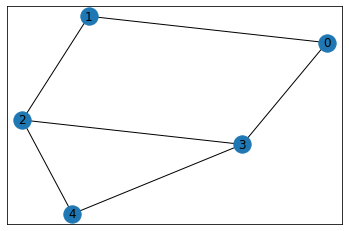

In [190]:
house_edge_index = torch.tensor([[0, 1, 0, 3, 1, 2, 2, 3, 2, 3, 4,],
                                 [1, 0, 3, 0, 2, 1, 3, 2, 4, 4, 3,]], dtype=torch.long)
graph = nx.from_edgelist(house_edge_index.numpy().T)
nx.draw_networkx(graph, with_labels=True)

In [191]:
from torch_geometric.data import Data
house = Data(edge_index=house_edge_index, x=torch.range(0, 4).view(5, 1), y=torch.tensor([1]))
house.num_nodes = house_edge_index.max().item() + 1
house_complex = compute_ring_2complex_with_graphtool_and_gudhi(house.x, house.edge_index, house.num_nodes,
                                                                   max_k=4, y=house.y)

<ipython-input-191-0ff48cbb3679>:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  house = Data(edge_index=house_edge_index, x=torch.range(0, 4).view(5, 1), y=torch.tensor([1]))


In [192]:
x = house.x
edge_index = house.edge_index
size = house.num_nodes
y = house.y
max_k = 4
include_down_adj = True
init_method = 'sum'

# Creates the gudhi-based simplicial complex
simplex_tree = pyg_to_simplex_tree(edge_index, size)
simplex_tree.expansion(1)  # Computes the clique complex up to the edge dim.
assert simplex_tree.dimension() == 1 # See what is the dimension of the complex now.

# Builds tables of the simplicial complexes at each level and their IDs
simplex_tables, id_maps = build_tables_with_rings(edge_index, simplex_tree, size, max_k)

# Extracts the faces and cofaces of each simplex in the complex
faces_tables, faces, co_faces = (
    extract_faces_and_cofaces_from_simplex_tree_with_rings(simplex_tree, id_maps))

# Computes the adjacencies between all the simplexes in the complex
shared_faces, shared_cofaces, lower_idx, upper_idx = build_adj_gudhi(faces, co_faces, id_maps,
                                                                     2, include_down_adj)

# Construct features for the higher dimensions
# TODO: Make this handle edge features as well and add alternative options to compute this.
xs = construct_features_with_rings(x, simplex_tables, init_method)

# Initialise the node / complex labels
v_y, complex_y = extract_labels(y, size)

chains = []
for i in range(3):
    y = v_y if i == 0 else None
    chain = generate_chain_gudhi(i, xs[i], upper_idx, lower_idx, shared_faces, shared_cofaces,
                                 simplex_tables, faces_tables, complex_dim=2, y=y, cells=(i==2))
    chains.append(chain)

complex = Complex(*chains, y=complex_y, dimension=2)

In [193]:
faces_tables

[[],
 [[0, 1], [0, 3], [1, 2], [2, 3], [2, 4], [3, 4]],
 [[0, 1, 2, 3], [3, 4, 5]]]

In [194]:
faces

[{},
 {(0, 1): [(0,), (1,)],
  (0, 3): [(0,), (3,)],
  (1, 2): [(1,), (2,)],
  (2, 3): [(2,), (3,)],
  (2, 4): [(2,), (4,)],
  (3, 4): [(3,), (4,)]},
 {(0, 1, 2, 3): [(0, 1), (0, 3), (1, 2), (2, 3)],
  (2, 3, 4): [(2, 3), (2, 4), (3, 4)]},
 {}]

In [195]:
co_faces

[{(0,): [(0, 1), (0, 3)],
  (1,): [(0, 1), (1, 2)],
  (2,): [(1, 2), (2, 3), (2, 4)],
  (3,): [(0, 3), (2, 3), (3, 4)],
  (4,): [(2, 4), (3, 4)]},
 {(0, 1): [(0, 1, 2, 3)],
  (0, 3): [(0, 1, 2, 3)],
  (1, 2): [(0, 1, 2, 3)],
  (2, 3): [(0, 1, 2, 3), (2, 3, 4)],
  (2, 4): [(2, 3, 4)],
  (3, 4): [(2, 3, 4)]},
 {},
 {}]

In [196]:
id_maps

[{(0,): 0, (1,): 1, (2,): 2, (3,): 3, (4,): 4},
 {(0, 1): 0, (0, 3): 1, (1, 2): 2, (2, 3): 3, (2, 4): 4, (3, 4): 5},
 {(0, 1, 2, 3): 0, (2, 3, 4): 1}]

In [197]:
simplex_tables

[[[0], [1], [2], [3], [4]],
 [[0, 1], [0, 3], [1, 2], [2, 3], [2, 4], [3, 4]],
 [[0, 1, 2, 3], [2, 3, 4]]]

In [199]:
complex.get_chain_params(1).up_index

tensor([[0, 1, 0, 2, 0, 3, 1, 2, 1, 3, 2, 3, 3, 4, 3, 5, 4, 5],
        [1, 0, 2, 0, 3, 0, 2, 1, 3, 1, 3, 2, 4, 3, 5, 3, 5, 4]])